<a href="https://colab.research.google.com/github/AndrzejOlejniczak/PORTFOLIO/blob/main/SkimLit_model_3_to_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Part TWO of the project*

## Get the data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.19 MiB/s, done.


In [ ]:
# Setup data dir
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [ ]:
# Create filenames
import os
filepaths = [data_dir + '/'+ filename for filename in os.listdir(data_dir)]

In [ ]:
filepaths

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Inspect the data

### Create a helper function

In [ ]:
def get_lines(filename):
  '''
  Reads text using filename and return lines of a text as a list.
  Args:
    filename: (str) containd filepath
  Returns:
    A list of strings.
  '''
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(filepaths[0])

### Check loaded data

In [ ]:
train_lines[:17]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

**The data is labeled but it isn't split to target / text pairs. We have to invent a way to parse and order it appropriatelly.**

## Prepare the data

Since we are looking for the a meaning of each sentence we can skip abstract signature lines like `'###24293578\n'` and additional spacing lines `'\n'`

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
def split_lines(lines):
  train_data = []
  train_data_with_nrows = []
  last_counter = 0
  counter = 0
  for i, row in enumerate(lines):
    if row[:3] != '\n':
      if row[:3] != '###':
        target, text = row.split('\t')[0], row.split('\t')[1].strip('\n')
        train_data.append([counter, target, text])
        counter+=1
      else:
        abstract_symbol = row.strip('\n')
        if i != 0:
          counter=0
    else:
      for el in train_data[-counter:]:
        train_data_with_nrows.append(el + [counter-1] + [abstract_symbol])
  return train_data_with_nrows

In [ ]:
%%time
train_data = split_lines(get_lines(filepaths[0]))
test_data = split_lines(get_lines(filepaths[1]))
val_data = split_lines(get_lines(filepaths[2]))

CPU times: user 757 ms, sys: 71.6 ms, total: 829 ms
Wall time: 879 ms


### Create DataFrames for train, test and validation data

In [ ]:
train_data_df = pd.DataFrame(train_data, columns = ['row', 'target', 'text', 'nrows', 'abstract'])
train_data_df.head(20), len(train_data_df)

(    row       target                                               text  \
 0     0    OBJECTIVE  To investigate the efficacy of @ weeks of dail...   
 1     1      METHODS  A total of @ patients with primary knee OA wer...   
 2     2      METHODS  Outcome measures included pain reduction and i...   
 3     3      METHODS  Pain was assessed using the visual analog pain...   
 4     4      METHODS  Secondary outcome measures included the Wester...   
 5     5      METHODS  Serum levels of interleukin @ ( IL-@ ) , IL-@ ...   
 6     6      RESULTS  There was a clinically relevant reduction in t...   
 7     7      RESULTS  The mean difference between treatment arms ( @...   
 8     8      RESULTS  Further , there was a clinically relevant redu...   
 9     9      RESULTS  These differences remained significant at @ we...   
 10   10      RESULTS  The Outcome Measures in Rheumatology Clinical ...   
 11   11  CONCLUSIONS  Low-dose oral prednisolone had both a short-te...   
 12    0   B

In [ ]:
test_data_df = pd.DataFrame(test_data, columns = ['row', 'target', 'text', 'nrows', 'abstract'])
test_data_df.head(20), len(test_data_df)

(    row       target                                               text  \
 0     0   BACKGROUND  IgE sensitization to Aspergillus fumigatus and...   
 1     1   BACKGROUND  It is not clear whether these patients would b...   
 2     2    OBJECTIVE  We sought to determine whether a @-month cours...   
 3     3      METHODS  Asthmatic patients who were IgE sensitized to ...   
 4     4      METHODS  Primary outcomes were improvement in quality o...   
 5     5      RESULTS              Sixty-five patients were randomized .   
 6     6      RESULTS  Fifty-nine patients started treatment ( @ rece...   
 7     7      RESULTS  Fifty-six patients took the full @ months of m...   
 8     8      RESULTS  Between the voriconazole and placebo groups , ...   
 9     9  CONCLUSIONS  We were unable to show a beneficial effect of ...   
 10    0   BACKGROUND  Opioid antagonists ( e.g. , naltrexone ) and p...   
 11    1   BACKGROUND  The use of higher doses to achieve greater eff...   
 12    2   B

In [ ]:
val_data_df = pd.DataFrame(val_data, columns = ['row', 'target', 'text', 'nrows', 'abstract'])
val_data_df.head(20), len(val_data_df)

(    row       target                                               text  \
 0     0   BACKGROUND  This study analyzed liver function abnormaliti...   
 1     1      RESULTS  A post hoc analysis was conducted with the use...   
 2     2      RESULTS  Liver function tests ( LFTs ) were measured at...   
 3     3      RESULTS  Survival analyses were used to assess the asso...   
 4     4      RESULTS  The percentage of patients with abnormal LFTs ...   
 5     5      RESULTS  When mean hemodynamic profiles were compared i...   
 6     6      RESULTS  Multivariable analyses revealed that patients ...   
 7     7  CONCLUSIONS  Abnormal LFTs are common in the ADHF populatio...   
 8     8  CONCLUSIONS  Elevated MELD-XI scores are associated with po...   
 9     0   BACKGROUND  Minimally invasive endovascular aneurysm repai...   
 10    1   BACKGROUND  The aim of this study was to analyse the cost-...   
 11    2      METHODS  Resource use was determined from the Amsterdam...   
 12    3    

In [ ]:
list_of_datasets = [train_data_df, test_data_df, val_data_df]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

### Create lists of strings for feature vectors

In [ ]:
# Create lists with txt data:
train_txt = train_data_df.text.str.lower().to_list()
test_txt = test_data_df.text.str.lower().to_list()
val_txt = val_data_df.text.str.lower().to_list()

len(train_txt), len(test_txt), len(val_txt)

(180040, 30212, 30135)

In [ ]:
train_txt[:7]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Create one-hot labels


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
# Instantiate the encoder
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
train_labels_onehot = one_hot_encoder.fit_transform(train_data_df.target.to_numpy().reshape(-1,1))

In [ ]:
train_labels_onehot.shape[1] == train_data_df.target.nunique(), train_labels_onehot.shape[0] == len(train_data_df.target)

(True, True)

In [ ]:
test_labels_onehot = one_hot_encoder.transform(test_data_df.target.to_numpy().reshape(-1,1))
val_labels_onehot  = one_hot_encoder.transform(val_data_df.target.to_numpy().reshape(-1,1))

In [ ]:
test_labels_onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
one_hot_encoder.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['x0_BACKGROUND', 'x0_CONCLUSIONS', 'x0_METHODS', 'x0_OBJECTIVE',
       'x0_RESULTS'], dtype=object)

### Create numeric labels
Which will be used for Multinomial Naive Bayes baseline model (model_0)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [ ]:
train_labels_encoded = label_encoder.fit_transform(train_data_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_data_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_data_df.target.to_numpy())

In [ ]:
len(train_labels_encoded) == len(train_data_df.target)

True

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

### Create text vectorization layer

In [ ]:
# Import modules
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding

In [ ]:
# Instantiate TextVectorization layer
text_vectorization = TextVectorization(
    max_tokens = 10000,
    standardize = 'lower_and_strip_punctuation',
    split='whitespace',
    ngrams=3,
    output_mode='int',
    output_sequence_length=27,
    pad_to_max_tokens=True,
)

In [ ]:
# Adapt the vectorizer to train_data
text_vectorization.adapt(train_txt)

In [ ]:
text_vectorization([train_data_df.text[0]])

<tf.Tensor: shape=(1, 27), dtype=int64, numpy=
array([[   6,  473,    2,   88,    4,   56,    4,  194, 2045,  279, 5668,
           5,  872,   68, 3095,    3, 1106,    1, 1047,    5,    2, 1078,
        2058,    3,  218,    2,   77]])>

In [ ]:
# Check tokenization with TextVectorizer vocabulary
for token in text_vectorization([train_data_df.text[0]])[0].numpy():
  print(f'Token: {token}, word: {text_vectorization.get_vocabulary()[token]}')

Token: 6, word: to
Token: 473, word: investigate
Token: 2, word: the
Token: 88, word: efficacy
Token: 4, word: of
Token: 56, word: weeks
Token: 4, word: of
Token: 194, word: daily
Token: 2045, word: lowdose
Token: 279, word: oral
Token: 5668, word: prednisolone
Token: 5, word: in
Token: 872, word: improving
Token: 68, word: pain
Token: 3095, word: mobility
Token: 3, word: and
Token: 1106, word: systemic
Token: 1, word: [UNK]
Token: 1047, word: inflammation
Token: 5, word: in
Token: 2, word: the
Token: 1078, word: short
Token: 2058, word: term
Token: 3, word: and
Token: 218, word: whether
Token: 2, word: the
Token: 77, word: effect


### Prepare data pipelines

In [ ]:
# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_txt, train_labels_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_txt, test_labels_onehot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_txt, val_labels_onehot))

In [ ]:
# Batch the datasets and turn them to prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 3: Conv1D with character embeddings

Character-level embeddings are used in the prototype paper: https://arxiv.org/abs/1612.05251

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
split_chars(train_txt[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# Split sequence-level data into character-level data
train_chars = [split_chars(sentence) for sentence in train_txt]

In [ ]:
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [ ]:
val_chars = [split_chars(sentence) for sentence in val_txt]
test_chars = [split_chars(sentence) for sentence in test_txt]

### Check the stats for character-wise lenght of the sequences

In [ ]:
train_data_len_characters = [len(characters.split(" ")) for characters in train_chars]
test_data_len_characters = [len(characters.split(" ")) for characters in test_chars]
val_data_len_characters = [len(characters.split(" ")) for characters in val_chars]

In [ ]:
train_data_len_characters_mean = np.mean(train_data_len_characters)
test_data_len_characters_mean = np.mean(test_data_len_characters)
val_data_len_characters_mean = np.mean(val_data_len_characters)

In [ ]:
train_data_len_characters_mean, test_data_len_characters_mean, val_data_len_characters_mean

(174.70452677182848, 174.6135641466967, 173.63842707814834)

**Looks like our magic number 175**

In [ ]:
MAGIC_NUMBER = 175

In [ ]:
len_characters = [train_data_len_characters, test_data_len_characters, val_data_len_characters]

In [ ]:
len(np.unique(len_characters[0]))

802

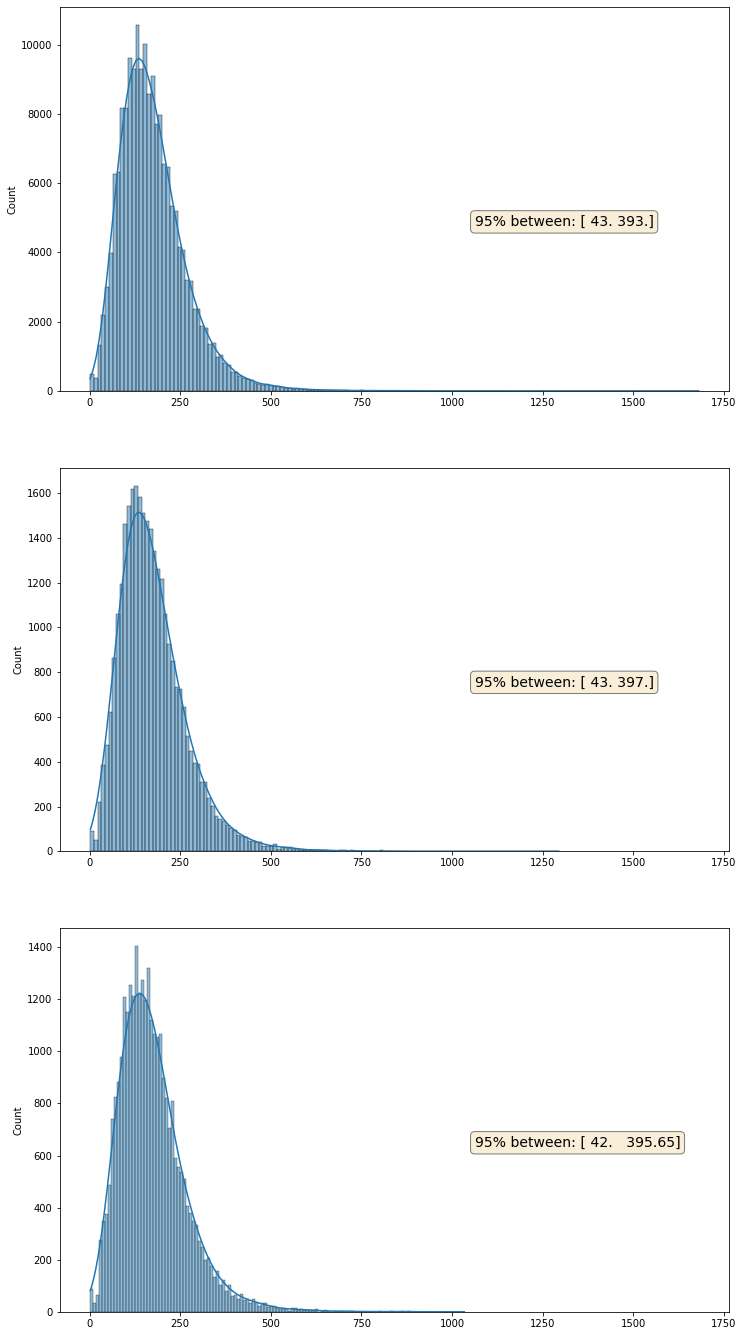

In [ ]:
fig = plt.figure(figsize=(12, 24))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312, sharex=ax1)
ax3 = plt.subplot(313, sharex=ax1)
axes = [ax1, ax2, ax3]
for it, dataset in enumerate(len_characters):
  sns.histplot(dataset, bins=int(len(np.unique(len_characters[it]))/5), ax=axes[it], kde=True, kde_kws={'bw_adjust':2.2} )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  axes[it].text(0.05, 0.95, f'95% between: {np.quantile(len_characters[it], [0.025, 0.975])}', transform=axes[it].transAxes, fontsize=14, position=(0.62,0.43), bbox=props)
plt.show()

## Create character-level datasets

In [ ]:
import tensorflow as tf

In [ ]:
np.array(val_chars).shape, val_labels_onehot.shape

((30135,), (30135, 5))

In [ ]:
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset= tf.data.Dataset.from_tensor_slices((test_chars, test_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset= tf.data.Dataset.from_tensor_slices((val_chars, val_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_chars_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Create character-lever vectorizer

In [ ]:
import string

In [ ]:
# Get all keybord characters
alphabet = string.ascii_lowercase + string.digits

alphabet

'abcdefghijklmnopqrstuvwxyz0123456789'

In [ ]:
# Setup parameters
NUM_CHAR_TOKENS = len(alphabet) + 2 # add space and OOV token
NUM_CHAR_TOKENS

38

In [ ]:
# Instantiate vectorizer
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length = MAGIC_NUMBER,
    standardize = 'lower_and_strip_punctuation',
    name = 'char_vectorizer'
)

In [ ]:
# Adapt character vectorizer to training data
char_vectorizer.adapt(train_chars)

In [ ]:
# Check vocab stats
char_vocab = char_vectorizer.get_vocabulary()

In [ ]:
len(char_vocab)

28

In [ ]:
print(char_vectorizer(train_chars[17]))

tf.Tensor(
[ 5  3  3  2  6  3  4  7  6  5 12 22  4  5  9  2  9 17  7  8 13  4 18 13
 11  5 12  7  8  4 11 17  7  7 10  9 20  2  8  2 15  2  5  9 16  8  2 10
 22 19  2 19  2  3  8  5 11 23  4  6 18 10 16  8  4  6 18  5 21  4  9 16
  5 12 14  8  7 22  2  3  5  9 23 20  4  3 13 14  4 11  3  7  8  4  5 12
 17  7  7 10  5  6 10  6  2 16  3  8  5 12  9  3  4 15 16 12  4  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0], shape=(175,), dtype=int64)


## Crete Embedding layer

In [ ]:
# Create an embedding layer for model_1
embedding_3 = Embedding(input_dim=len(char_vocab),
                      output_dim=25, # number assumed in the paper
                      mask_zero=True,
                      name='char_embed')

In [ ]:
embedding_3(char_vectorizer(train_chars[17]))

<tf.Tensor: shape=(175, 25), dtype=float32, numpy=
array([[-0.03136908, -0.0452494 , -0.04114179, ..., -0.03606336,
         0.02699813,  0.03086153],
       [ 0.03136226,  0.04571639,  0.01233157, ...,  0.03120791,
         0.02938015,  0.04583435],
       [ 0.00963838, -0.02566481, -0.04107727, ..., -0.00156822,
        -0.03664466,  0.04125499],
       ...,
       [ 0.01717143,  0.01608654,  0.02271343, ..., -0.03240824,
         0.02756022, -0.01266183],
       [ 0.01717143,  0.01608654,  0.02271343, ..., -0.03240824,
         0.02756022, -0.01266183],
       [ 0.01717143,  0.01608654,  0.02271343, ..., -0.03240824,
         0.02756022, -0.01266183]], dtype=float32)>

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense

## Create model 3

In [ ]:
# Create model_3 using functional API
inputs = Input(shape=(1,), dtype='string')
x = char_vectorizer(inputs)
x = embedding_3(x)
x = Conv1D(filters=16, kernel_size=5, padding='same')(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(5, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_charEmbedConv1D')

In [ ]:
model_3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
model_3.summary()

Model: "model_3_charEmbedConv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 175)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 175, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 175, 16)           2016      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)     

In [ ]:
history_3 = model_3.fit(
    train_chars_dataset,
    epochs=25,
    validation_data=val_chars_dataset,
)

Epoch 1/25
942/942 [==============================] - 24s 17ms/step - loss: 1.3117 - accuracy: 0.4494 - val_loss: 1.1695 - val_accuracy: 0.5155
Epoch 2/25
942/942 [==============================] - 16s 17ms/step - loss: 1.1201 - accuracy: 0.5388 - val_loss: 1.0828 - val_accuracy: 0.5592
Epoch 3/25
942/942 [==============================] - 16s 17ms/step - loss: 1.0501 - accuracy: 0.5743 - val_loss: 1.0371 - val_accuracy: 0.5821
Epoch 4/25
942/942 [==============================] - 16s 17ms/step - loss: 1.0091 - accuracy: 0.5916 - val_loss: 1.0058 - val_accuracy: 0.5975
Epoch 5/25
942/942 [==============================] - 17s 18ms/step - loss: 0.9776 - accuracy: 0.6060 - val_loss: 0.9818 - val_accuracy: 0.6102
Epoch 6/25
942/942 [==============================] - 17s 18ms/step - loss: 0.9529 - accuracy: 0.6181 - val_loss: 0.9620 - val_accuracy: 0.6191
Epoch 7/25
942/942 [==============================] - 17s 18ms/step - loss: 0.9297 - accuracy: 0.6318 - val_loss: 0.9443 - val_accuracy:

### Evaluate Model 3

In [ ]:
from BERI_helper_functions import create_crp, plot_curves_eval
from sklearn.metrics import classification_report

In [ ]:
model_3_eval = model_3.evaluate(test_chars_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8606 - accuracy: 0.6659


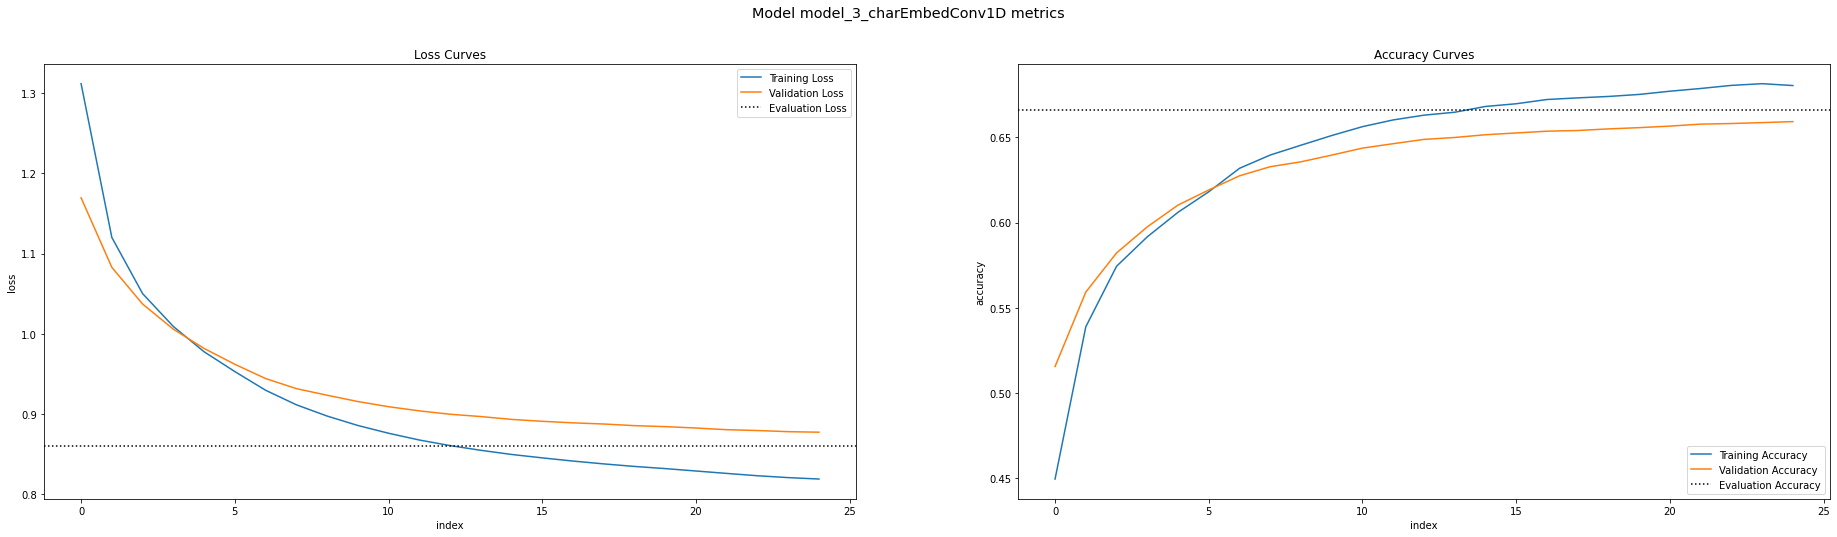

In [ ]:
# Plot the curves
plot_curves_eval(history=history_3, eval_acc=model_3_eval[1], eval_loss=model_3_eval[0])

In [ ]:
model_3_pred_probs = model_3.predict(test_chars_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.9052069 , 0.8133723 , 0.46877983, 0.790669  , 0.11851994],
       [0.83721143, 0.83452487, 0.58998936, 0.57566756, 0.17483109],
       [0.87941116, 0.528766  , 0.746403  , 0.8897289 , 0.03444424],
       ...,
       [0.5511943 , 0.86853194, 0.64860034, 0.14837964, 0.91811556],
       [0.23930895, 0.4619617 , 0.9640649 , 0.0814479 , 0.7172288 ],
       [0.94539225, 0.9456418 , 0.57171375, 0.36052573, 0.5419158 ]],
      dtype=float32)

In [ ]:
model_3_pred_probs.shape

(30212, 5)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

In [ ]:
model_3_preds, model_3_preds.shape

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 1])>,
 TensorShape([30212]))

In [ ]:
model_3_crp = classification_report(model_3_preds, test_labels_encoded,  output_dict=True)

In [ ]:
model_3_crp_df = create_crp(model_3_crp, label_encoder.classes_, experiment_name='Model 3: Conv1D char')

In [ ]:
model_3_crp_df

Model 3: Conv1D char                                  
                         precision    recall  f1-score       support
0_background              0.455784  0.456977  0.456380   3440.000000
1_conclusions             0.491925  0.482862  0.487351   4668.000000
2_methods                 0.823665  0.711117  0.763264  11541.000000
3_objective               0.436869  0.684697  0.533402   1516.000000
4_results                 0.715984  0.778822  0.746082   9047.000000
accuracy                  0.665861  0.665861  0.665861      0.665861
macro avg                 0.584845  0.622895  0.597296  30212.000000
weighted avg              0.678867  0.665861  0.669012  30212.000000

## Model 4: Combined pretrained token embeddings + character embeddings

In [ ]:
# Download TFHub USE
import tensorflow_hub as hub
USE_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', trainable=False)

### Create token embedding submodel

In [ ]:
token_inputs = Input(shape=[], dtype=tf.string, name='token_inputs')
token_embedding = USE_embedding(token_inputs)
token_output = Dense(128, activation='relu')(token_embedding)

token_model = tf.keras.Model(inputs=token_inputs, outputs = token_output )

In [ ]:
token_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_inputs (InputLayer)   [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
Total params: 256,863,488
Trainable params: 65,664
Non-trainable params: 256,797,824
_________________________________________________________________


### Create character embedding submodel

In [ ]:
# Create char embedding layer
embedding_4 = Embedding(input_dim=len(char_vocab),
                      output_dim=25, # number assumed in the paper
                      mask_zero=True,
                      name='char_embed')

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout

In [ ]:
char_inputs = Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = embedding_4(char_vectors)
char_bi_lstm = Bidirectional(LSTM(24))(char_embedding)

chars_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

In [ ]:
chars_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_input (InputLayer)     [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 175)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 175, 25)           700       
                                                                 
 bidirectional (Bidirectiona  (None, 48)               9600      
 l)                                                              
                                                                 
Total params: 10,300
Trainable params: 10,300
Non-trainable params: 0
_________________________________________________________________


### Concatenate outputs of chars_model and token_model

In [ ]:
from tensorflow.keras.layers import Concatenate

In [ ]:
token_char_concat = Concatenate(name='concat_tok_char')([token_model.output, chars_model.output])

### Create output layer seaquence and build model 4

---



In [ ]:
combined_dropout = Dropout(.5)(token_char_concat)
combined_dense = Dense(128, activation='relu')(combined_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(5, activation='softmax')(final_dropout)

In [ ]:
len(list(train_chars_dataset)), len(list(train_dataset))

(5627, 5627)

In [ ]:
model_4 = tf.keras.Model(
    inputs=[token_model.input, chars_model.input],
    outputs=output_layer,
    name='tok_char_embed'
)

In [ ]:
model_4.summary()

Model: "tok_char_embed"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 175)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_inputs[0][0]

In [ ]:
from tensorflow.keras.utils import plot_model

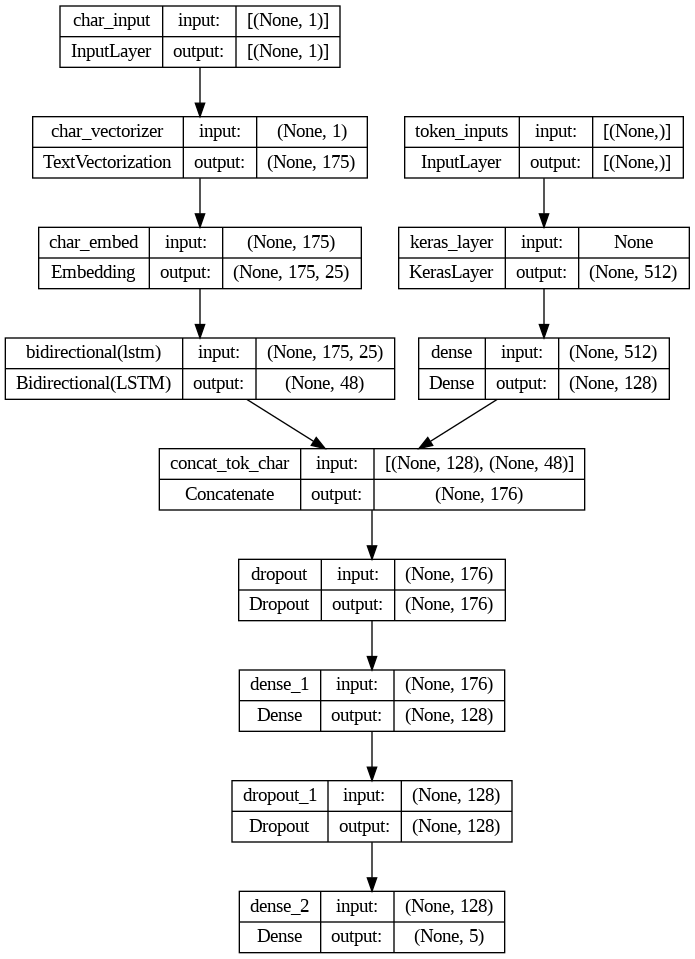

In [ ]:
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile the model
model_4.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

### Create data pipeline for combined input

#### Train data

In [ ]:
train_tokchar_data = tf.data.Dataset.from_tensor_slices((train_txt, train_chars))
train_tokchar_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot)

train_tokchar_dataset = tf.data.Dataset.zip((train_tokchar_data, train_tokchar_labels))

In [ ]:
train_tokchar_dataset = train_tokchar_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#### Test data

In [ ]:
test_tokchar_data = tf.data.Dataset.from_tensor_slices((test_txt, test_chars))
test_tokchar_labels = tf.data.Dataset.from_tensor_slices(test_labels_onehot)

test_tokchar_dataset = tf.data.Dataset.zip((test_tokchar_data, test_tokchar_labels))

In [ ]:
test_tokchar_dataset = test_tokchar_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#### Validation data

In [ ]:
val_tokchar_data = tf.data.Dataset.from_tensor_slices((val_txt, val_chars))
val_tokchar_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot)

val_tokchar_dataset = tf.data.Dataset.zip((val_tokchar_data, val_tokchar_labels))

In [ ]:
val_tokchar_dataset = val_tokchar_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_tokchar_dataset, test_tokchar_dataset, val_tokchar_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fit the model

In [ ]:
history_4 = model_4.fit(
    train_tokchar_dataset,
    epochs=25,
    validation_data=val_tokchar_dataset,
)

Epoch 1/25
5627/5627 [==============================] - 185s 31ms/step - loss: 0.7680 - accuracy: 0.7061 - val_loss: 0.6488 - val_accuracy: 0.7522
Epoch 2/25
5627/5627 [==============================] - 168s 30ms/step - loss: 0.6844 - accuracy: 0.7428 - val_loss: 0.6198 - val_accuracy: 0.7637
Epoch 3/25
5627/5627 [==============================] - 169s 30ms/step - loss: 0.6615 - accuracy: 0.7503 - val_loss: 0.6072 - val_accuracy: 0.7697
Epoch 4/25
5627/5627 [==============================] - 169s 30ms/step - loss: 0.6449 - accuracy: 0.7570 - val_loss: 0.5971 - val_accuracy: 0.7719
Epoch 5/25
5627/5627 [==============================] - 168s 30ms/step - loss: 0.6332 - accuracy: 0.7626 - val_loss: 0.5915 - val_accuracy: 0.7764
Epoch 6/25
5627/5627 [==============================] - 167s 30ms/step - loss: 0.6245 - accuracy: 0.7665 - val_loss: 0.5867 - val_accuracy: 0.7769
Epoch 7/25
5627/5627 [==============================] - 166s 30ms/step - loss: 0.6170 - accuracy: 0.7687 - val_loss: 0

### Evaluate Model 4

In [ ]:
model_4_eval = model_4.evaluate(test_tokchar_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.5285 - accuracy: 0.8026


In [ ]:
from BERI_helper_functions import plot_curves_eval, create_crp

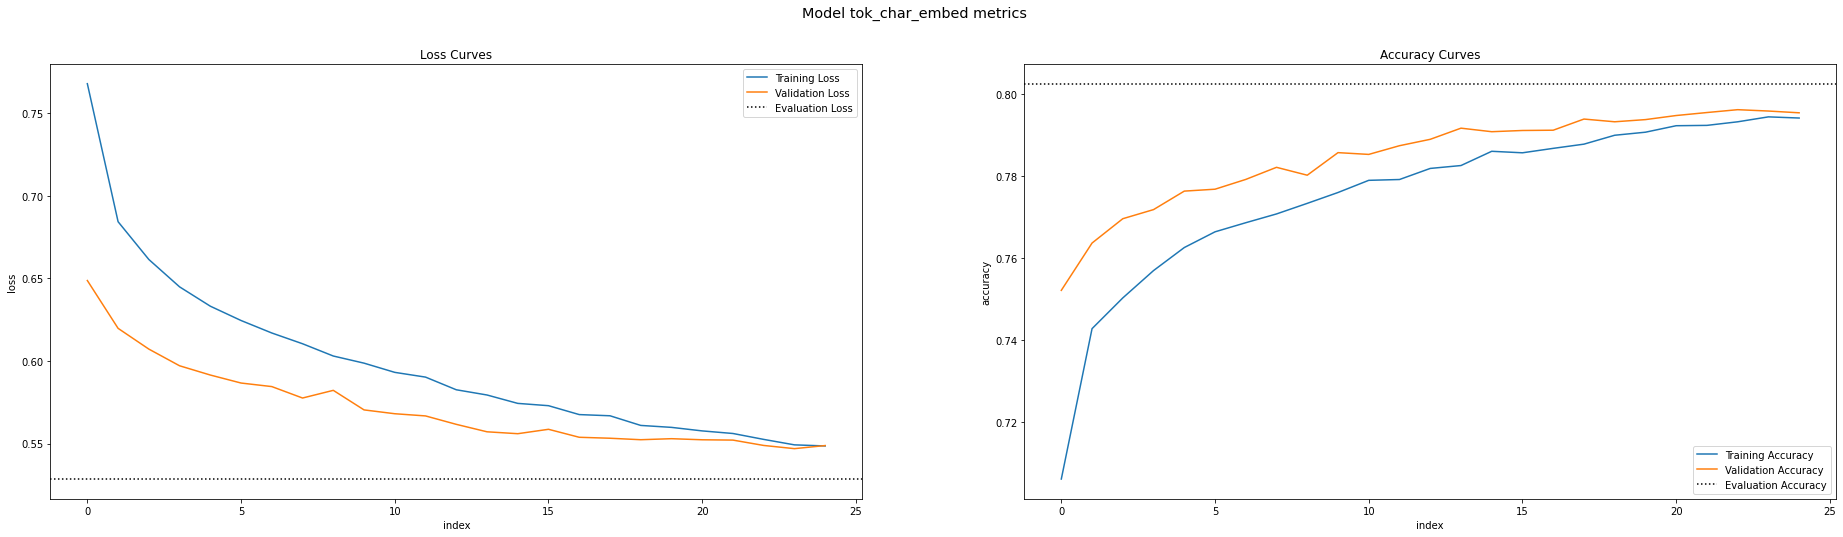

In [ ]:
# Plot the curves
plot_curves_eval(history=history_4, eval_acc=model_4_eval[1], eval_loss=model_4_eval[0])

In [ ]:
model_4_pred_probs = model_4.predict(test_tokchar_dataset)
model_4_pred_probs

945/945 [==============================] - 17s 15ms/step


array([[6.0445118e-01, 1.7336452e-01, 2.7245018e-04, 2.2026129e-01,
        1.6505418e-03],
       [4.4368511e-01, 3.9349702e-01, 5.8457401e-04, 1.6081229e-01,
        1.4210262e-03],
       [5.0661087e-01, 1.4472058e-03, 1.5966125e-02, 4.7560564e-01,
        3.7022645e-04],
       ...,
       [1.9654547e-06, 1.2554989e-04, 2.0039792e-04, 2.7858297e-07,
        9.9967182e-01],
       [7.8460136e-03, 7.4594051e-02, 1.0162767e-01, 2.0738668e-03,
        8.1385839e-01],
       [1.6117111e-03, 9.9736005e-01, 4.3293872e-05, 4.7674745e-05,
        9.3728246e-04]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
model_4_crp = classification_report(model_4_preds, test_labels_encoded,  output_dict=True)

In [ ]:
model_4_crp_df = create_crp(model_4_crp, label_encoder.classes_, experiment_name='Model 4: tok&char embed')

In [ ]:
model_4_crp_df

Model 4: tok&char embed                                  
                            precision    recall  f1-score       support
0_background                 0.652073  0.624722  0.638105   3600.000000
1_conclusions                0.705151  0.708708  0.706925   4559.000000
2_methods                    0.904757  0.861937  0.882828  10459.000000
3_objective                  0.459175  0.834736  0.592452   1307.000000
4_results                    0.880297  0.842131  0.860791  10287.000000
accuracy                     0.802628  0.802628  0.802628      0.802628
macro avg                    0.720291  0.774447  0.736220  30212.000000
weighted avg                 0.816922  0.802628  0.807058  30212.000000

### Create a version of model 4 with bi-directional LSTM layer after concatenation
(and use already trained character embedding layer)

In [ ]:
# Create char embedding layer
embedding_4_1 = Embedding(input_dim=len(char_vocab),
                      output_dim=25, # number assumed in the paper
                      mask_zero=True,
                      name='char_embed_4_1')

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout

In [ ]:
char_inputs = Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = embedding_4_1(char_vectors)
char_bi_lstm = Bidirectional(LSTM(24))(char_embedding)

chars_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

In [ ]:
# We need to reshape input to the Bidirectional LSTM layer
from tensorflow.keras.layers import Reshape

In [ ]:
combined_dropout = Dropout(.5)(token_char_concat)
reshape = Reshape( (16, 11), input_shape=(176,))(combined_dropout)
combined_bidir = Bidirectional(LSTM(16))(reshape)
another_dropout = Dropout(0.5)(combined_dense)
output_layer_2 = Dense(5, activation='softmax')(another_dropout)

In [ ]:
model_4_1 = tf.keras.Model(
    inputs=[token_model.input, chars_model.input],
    outputs=output_layer_2,
    name='tok_char_embed_2'
)

In [ ]:
model_4_1.summary()

In [ ]:
plot_model(model_4_1, show_shapes=True)

In [ ]:
# Compile the model
model_4_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
history_4_1 = model_4_1.fit(
    train_tokchar_dataset,
    epochs=25,
    validation_data=val_tokchar_dataset,
)

Epoch 1/25
942/942 [==============================] - 119s 118ms/step - loss: 0.7365 - accuracy: 0.7284 - val_loss: 0.6464 - val_accuracy: 0.7580
Epoch 2/25
942/942 [==============================] - 106s 113ms/step - loss: 0.5430 - accuracy: 0.7972 - val_loss: 0.6371 - val_accuracy: 0.7597
Epoch 3/25
942/942 [==============================] - 107s 113ms/step - loss: 0.5124 - accuracy: 0.8105 - val_loss: 0.6380 - val_accuracy: 0.7609
Epoch 4/25
942/942 [==============================] - 106s 113ms/step - loss: 0.4974 - accuracy: 0.8140 - val_loss: 0.6395 - val_accuracy: 0.7617
Epoch 5/25
942/942 [==============================] - 106s 113ms/step - loss: 0.4881 - accuracy: 0.8137 - val_loss: 0.6430 - val_accuracy: 0.7617
Epoch 6/25
942/942 [==============================] - 106s 113ms/step - loss: 0.4824 - accuracy: 0.8177 - val_loss: 0.6460 - val_accuracy: 0.7615
Epoch 7/25
942/942 [==============================] - 106s 113ms/step - loss: 0.4805 - accuracy: 0.8173 - val_loss: 0.6469 -

### Let's experiment with Gaussian Dropout

In [ ]:
# Create character embedding layer 4_1

embedding_4_2 = Embedding(input_dim=len(char_vocab),
                      output_dim=25, # number assumed in the paper
                      mask_zero=True,
                      name='char_embed')

In [ ]:
# Create character model with the new embedding
char_inputs_4_2 = Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs_4_2)
char_embedding_4_2 = embedding_4_2(char_vectors)
char_bi_lstm = Bidirectional(LSTM(24))(char_embedding_4_2)

chars_model_4_2 = tf.keras.Model(inputs=char_inputs_4_2, outputs=char_bi_lstm)

In [ ]:
chars_model_4_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_input (InputLayer)     [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 175)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 175, 25)           700       
                                                                 
 bidirectional_3 (Bidirectio  (None, 48)               9600      
 nal)                                                            
                                                                 
Total params: 10,300
Trainable params: 10,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create roed token model
token_inputs_4_2 = Input(shape=[], dtype=tf.string, name='token_inputs')
token_embedding = USE_embedding(token_inputs_4_2)
token_output_4_2 = Dense(128, activation='relu')(token_embedding)

token_model_4_2 = tf.keras.Model(inputs=token_inputs_4_2, outputs = token_output_4_2 )

In [ ]:
token_model_4_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_inputs (InputLayer)   [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
Total params: 256,863,488
Trainable params: 65,664
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Create concatenation
token_char_concat_4_2 = Concatenate(name='concat_tok_char')([token_model_4_2.output, chars_model_4_2.output])

In [ ]:
from tensorflow.keras.layers import GaussianDropout

In [ ]:
# Create combined model
combined_gauss_dropout = GaussianDropout(.5)(token_char_concat_4_2)
reshape = Reshape( (16, 11), input_shape=(176,))(combined_gauss_dropout)
combined_bidir_4_2 = Bidirectional(LSTM(16))(reshape)
final_dropout_4_2 = Dropout(0.5)(combined_bidir_4_2)
output_layer_4_2 = Dense(5, activation='softmax')(final_dropout_4_2)

In [ ]:
model_4_2 = tf.keras.Model(
    inputs=[token_model_4_2.input, chars_model_4_2.input],
    outputs=output_layer_4_2,
    name='tok_char_embed_4_2'
)

In [ ]:
model_4_2.summary()

Model: "tok_char_embed_4_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 175)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_inputs[0

In [ ]:
# Compile the model
model_4_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
history_4_2 = model_4_2.fit(
    train_tokchar_dataset,
    epochs=50,
    validation_data=val_tokchar_dataset,
)

Epoch 1/50
5627/5627 [==============================] - 196s 33ms/step - loss: 0.8306 - accuracy: 0.6817 - val_loss: 0.6904 - val_accuracy: 0.7417
Epoch 2/50
5627/5627 [==============================] - 194s 34ms/step - loss: 0.7170 - accuracy: 0.7348 - val_loss: 0.6506 - val_accuracy: 0.7563
Epoch 3/50
5627/5627 [==============================] - 184s 33ms/step - loss: 0.6875 - accuracy: 0.7476 - val_loss: 0.6281 - val_accuracy: 0.7645
Epoch 4/50
5627/5627 [==============================] - 184s 33ms/step - loss: 0.6670 - accuracy: 0.7545 - val_loss: 0.6156 - val_accuracy: 0.7694
Epoch 5/50
5627/5627 [==============================] - 184s 33ms/step - loss: 0.6528 - accuracy: 0.7602 - val_loss: 0.6166 - val_accuracy: 0.7699
Epoch 6/50
5627/5627 [==============================] - 186s 33ms/step - loss: 0.6427 - accuracy: 0.7639 - val_loss: 0.6077 - val_accuracy: 0.7713
Epoch 7/50
5627/5627 [==============================] - 184s 33ms/step - loss: 0.6353 - accuracy: 0.7660 - val_loss: 0

### Evaluate Model 4_2

In [ ]:
sns.set_style('whitegrid')

In [ ]:
def plot_curves_eval(history, eval_acc=0.5, eval_loss=0.5):

    '''
    Uses seaborn and to plot curves
    as scatterplot with regression
    attrs:
    history: tf history object
    eval_acc: (float) evaluation accuracy
    eval_loss: (float) evaluation loss
    '''
    from matplotlib import ticker

    def forward(x):
        return x**(1/3)


    def inverse(x):
        return x**3

    # Create DataFrame
    df = pd.DataFrame(history.history)
    df.head()

    # Setup the figure
    plt.figure(figsize=(32, 11))
    plt.suptitle(f'Model {history.model.name} metrics', fontsize='x-large')

    # Setup loss axis
    ax1 = plt.subplot(1, 2, 1)

    # Plot grid
    ax1.grid(visible=True, which='major', axis='y', linestyle='-', color='gray')
    ax1.grid(visible=True, which='minor', axis='y', linestyle='--')

    # Setup y scale
    ax1.set_yscale('function', functions=(forward, inverse))

    # Setup ylim
    ax1.set_ylim(0.4, 0.9)

    # Setup ticks and grid
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax1.yaxis.set_ticks_position('left')
    ax1.tick_params(which='major', width=1.00, length=5)
    ax1.tick_params(which='minor', width=0.75, length=5)

    # Plot loss
    sns.lineplot(x='index', y='loss', data=df.reset_index(),
                label='Training Loss')
    sns.lineplot(x='index', y='val_loss', data=df.reset_index(),
                label='Validation Loss')
    plt.axhline(y=eval_loss, label='Evaluation Loss', color='black', linestyle=':')
    plt.legend()
    plt.title('Loss Curves')

    # Setup accuracy axis
    ax2 = plt.subplot(1, 2, 2)

    # Plot grid
    ax2.grid(visible=True, which='major', axis='y', linestyle='-', color='gray')
    ax2.grid(visible=True, which='minor', axis='y', linestyle='--')

    # Setup yscale
    ax2.set_yscale('function', functions=(inverse, forward))

    # Setup ylim
    ax2.set_ylim(0.5, 1.0)

    # Setup ticks
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))

    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')

    ax2.tick_params(which='major', width=1.00, length=5)
    ax2.tick_params(which='minor', width=0.75, length=5)



    # Plot Accuracy
    sns.lineplot(x='index', y='accuracy', data=df.reset_index(),
                label='Training Accuracy')
    sns.lineplot(x='index', y='val_accuracy', data=df.reset_index(),
                label='Validation Accuracy')
    plt.axhline(y=eval_acc, label='Evaluation Accuracy', color='black', linestyle=':')
    plt.legend()
    plt.title('Accuracy Curves')


In [ ]:
from BERI_helper_functions import plot_curves_eval, create_crp

In [ ]:
model_4_2_eval = model_4_2.evaluate(test_tokchar_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.5782 - accuracy: 0.7963


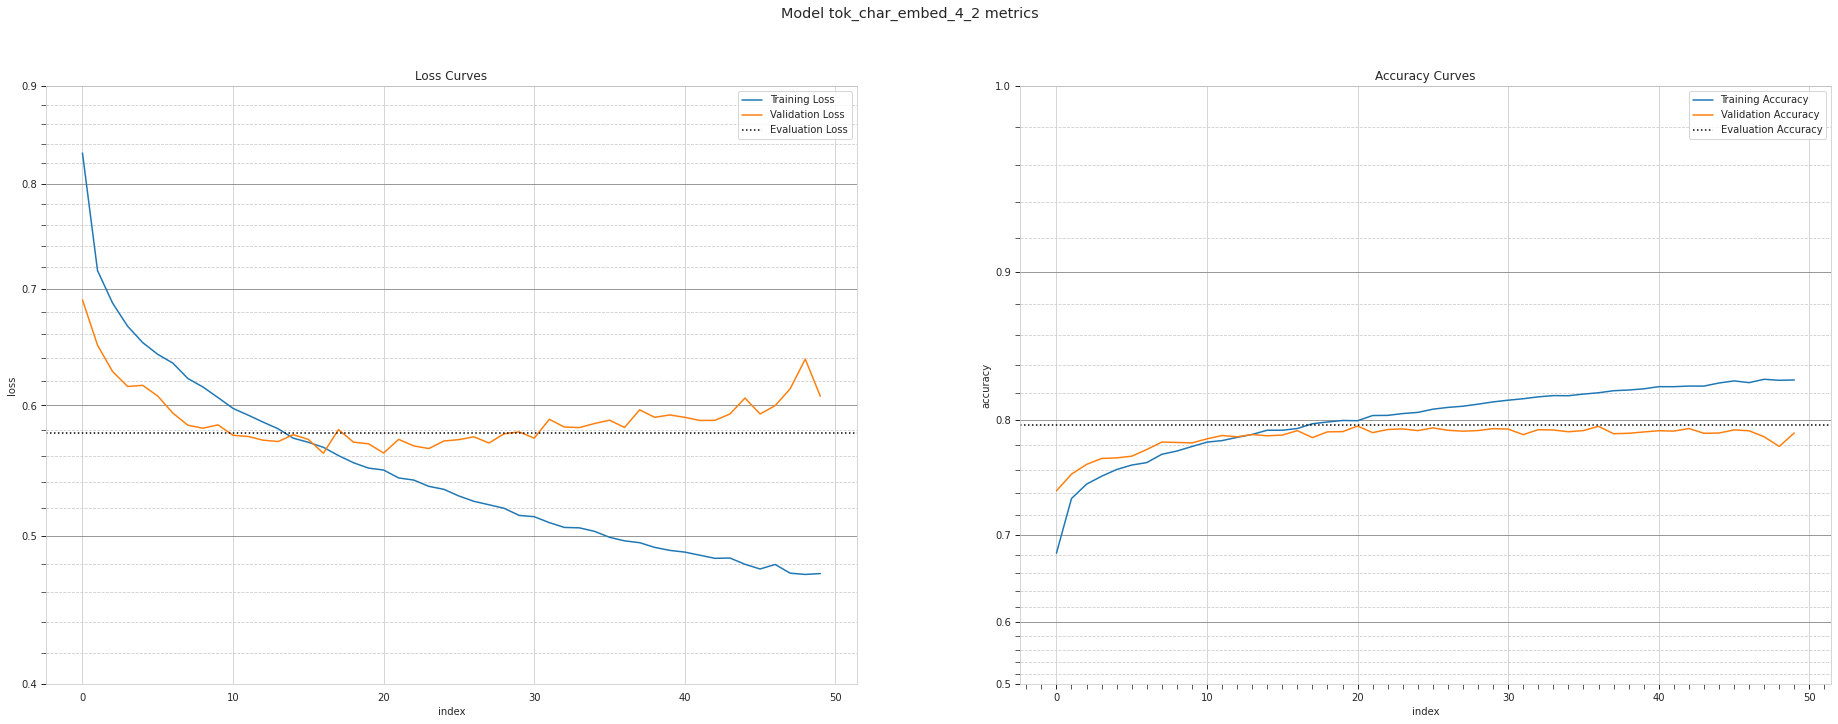

In [ ]:
# Plot the curves
plot_curves_eval(history=history_4_2, eval_acc=model_4_2_eval[1], eval_loss=model_4_2_eval[0])

In [ ]:
model_4_2_pred_probs = model_4_2.predict(test_tokchar_dataset)
model_4_2_pred_probs

945/945 [==============================] - 17s 15ms/step


array([[6.0445118e-01, 1.7336452e-01, 2.7245018e-04, 2.2026129e-01,
        1.6505418e-03],
       [4.4368511e-01, 3.9349702e-01, 5.8457401e-04, 1.6081229e-01,
        1.4210262e-03],
       [5.0661087e-01, 1.4472058e-03, 1.5966125e-02, 4.7560564e-01,
        3.7022645e-04],
       ...,
       [1.9654547e-06, 1.2554989e-04, 2.0039792e-04, 2.7858297e-07,
        9.9967182e-01],
       [7.8460136e-03, 7.4594051e-02, 1.0162767e-01, 2.0738668e-03,
        8.1385839e-01],
       [1.6117111e-03, 9.9736005e-01, 4.3293872e-05, 4.7674745e-05,
        9.3728246e-04]], dtype=float32)

In [ ]:
model_4_2_preds = tf.argmax(model_4_2_pred_probs, axis=1)

In [ ]:
model_4_2_crp = classification_report(model_4_2_preds, test_labels_encoded,  output_dict=True)

In [ ]:
model_4_2_crp_df = create_crp(model_4_2_crp, label_encoder.classes_, experiment_name='Model 4: tok&char embed')

In [ ]:
model_4_2_crp_df